Adapted in notebook time_series_gp_s+l_pulse_kernel_step_by_step:
- Use data file sim_pulse.lc
- Find the best kernel mixture for the stellar oscillations, step by step

In [1]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("../../data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')

In [22]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X)[:,None], np.array(Y)[:,None]   # Gpy requires a [(N, 1)] shape

# 1. Exploratory
## Plot the data

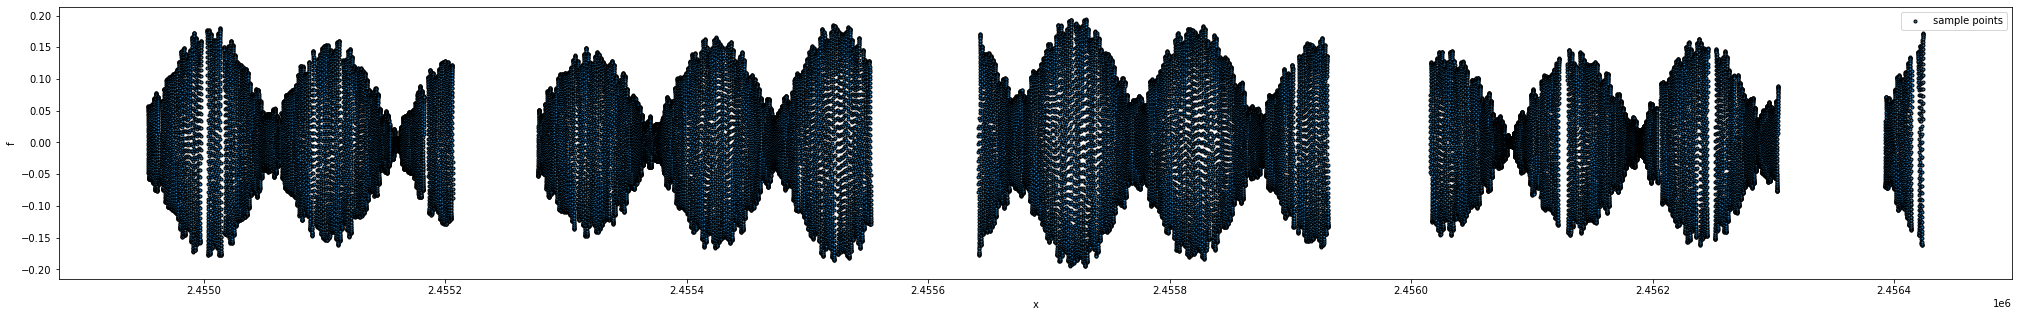

In [23]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

## Downsample

In [24]:
# Need to reduce further to 12800 points as N//4 doesn't work
X_part, Y_part = X[1::4][:12800], Y[1::4][:12800]
N_sampled = X_part.shape[0]   # Use a number that can be divided by 4. N//4
N_sampled

12800

In [25]:
X.min(), X.max()

(2454953.5392269692, 2456424.001734486)

In [26]:
X[1::4].min(), X[1::4].max()

(2454953.5596612184, 2456423.960865978)

Select a subset for training the kernel

In [27]:
N_part = N_sampled

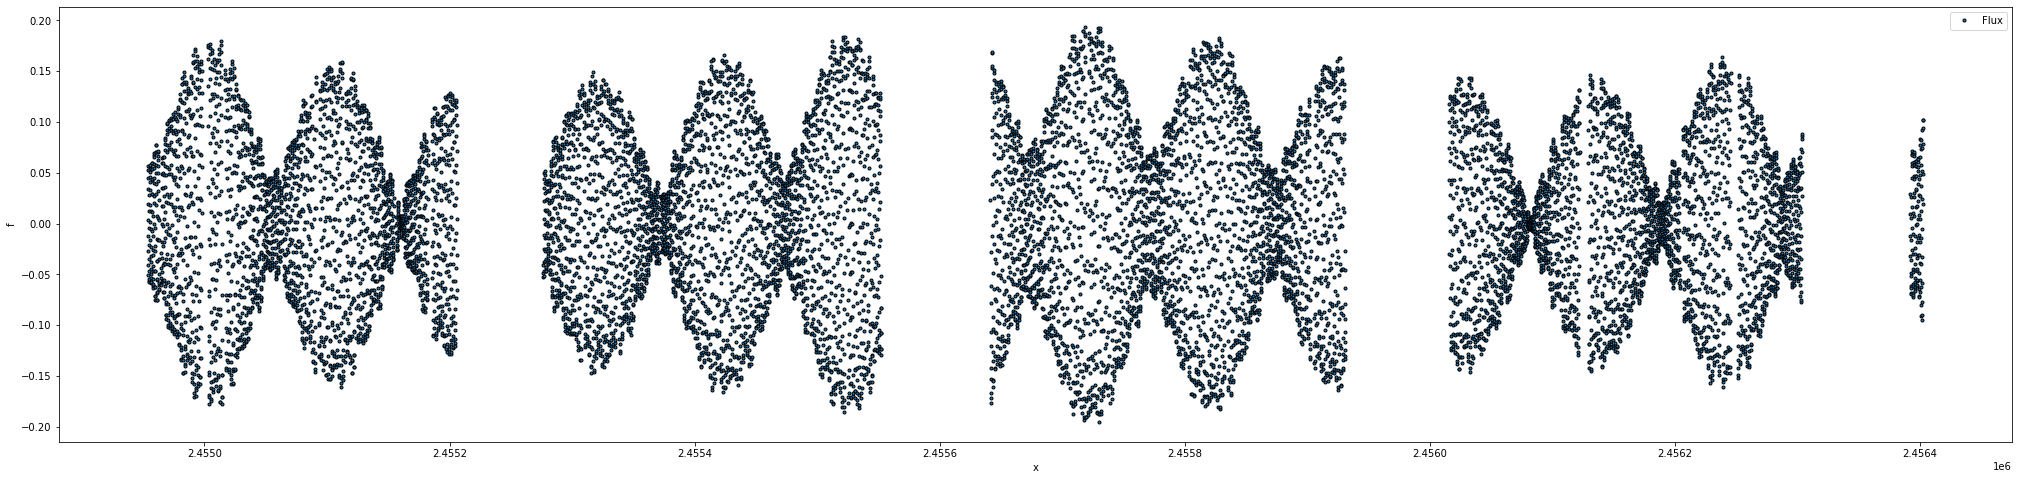

In [28]:
# Setup our figure environment
plt.figure(figsize=(35, 8))

# Plot observations
plt.plot(X_part, Y_part, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [29]:
def plot_kernel_samples(covariance_matrix, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    Y_sample = covariance_matrix.sample(nr_of_samples)
    N = cov_matrix.W.shape[0]
    for i in range(nr_of_samples):
        plt.plot(range(N), Y_sample[i])

def plot_kernel(covariance_matrix):
    # Our sample space
    X = np.linspace(-5., 5., 250)[:, None]
    C = covariance_matrix.chi2(X)
      
    # Visualise covariance matrix on right hand side
    plt.pcolor(X.T, X, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()
    
def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()

def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])
    
    plt.plot(train_x, train_y, "r:", lw=1)

In [30]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.linspace(X_part.min(), X_part.max(), N_part)

In [31]:
X_part.shape

(12800, 1)

In [32]:
# Initialize the GPy model
per1_kern = GPy.kern.StdPeriodic(input_dim=1, period=1/0.5673, lengthscale=7.40029)     # Periodicity

kernel = per1_kern
m = GPy.models.GPRegression(X_part, Y_part, kernel)

In [33]:
m.optimize()

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [ ]:
m

In [ ]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.array(np.linspace(X_part.min(),X_part.max(),N))[:,None]

# Get mean and covariance of optimised GP
mu_part_smooth, var_part_smooth = m.predict(X_part_smooth, full_cov=True)

# Setup the figure environment
plt.figure(figsize=(25, 5))



In [ ]:
plot_kernel_samples(cov_matrix, 1)

In [ ]:
plot_series(X_part, Y_part, X_part_smooth, mu_part_smooth, var_part_smooth)
# Plot the GP fit mean and covariance
plot_gp(X_part_smooth, mu_part_smooth, var_part_smooth, training_points=(X_part, Y_part))
plt.plot(X_part, Y_part, "r:", lw=1)

## Explore the parameters of the fitted model

In [ ]:
cov_matrix.param

In [ ]:
cov_matrix.get_param('sho.sig'), cov_matrix.get_param('sho.P0'), cov_matrix.get_param('sho.Q')

## Model Evaluation

RMSE

In [ ]:
mu_part, var_part = cov_matrix.conditional(Y_part, X_part, calc_cov='diag')

np.sqrt(np.nanmean((mu_part-Y_part)**2))

RMSE per x

In [ ]:
np.sqrt(np.nanmean((mu_part-Y_part)**2))/N_part

# Residuals
Calculate the residuals after fitting the model for our next step.

In [ ]:
resid1_part = Y_part - mu_part

In [ ]:
Y_part, mu_part, resid1_part

In [ ]:
plot_series(X_part, resid1_part)

The residuals are very small compared to Y (e-14).
Yet, there is still a periodic signal, this is not stationary yet

## Stage 2: Model the residuals

In [ ]:
# Initialize the S+LEAF model
cov_matrix2 = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.0000000004314, P0=1.7937, Q=200000.36505))

In [ ]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res2,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix2.get_param(), args=(resid1_part, cov_matrix2, params_to_fit))
cov_matrix2.set_param(xbest_res2, params_to_fit)

In [ ]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_res2_part_smooth, var_res2_part_smooth = cov_matrix2.conditional(resid1_part, X_part_smooth, calc_cov='diag')

In [ ]:
plot_series(X_part, resid1_part, X_part_smooth, mu_res2_part_smooth, 0)

In [ ]:
cov_matrix2.get_param('sho.sig'), cov_matrix2.get_param('sho.P0'), cov_matrix2.get_param('sho.Q')

In [ ]:
mu_res2_part, _ = cov_matrix2.conditional(resid1_part, X_part, calc_cov='diag')
resid2_part = resid1_part - mu_res2_part
resid1_part, mu_res2_part, resid2_part

In [ ]:
plot_series(X_part, resid2_part)

## Stage 3: Model the residuals

In [ ]:
# Initialize the S+LEAF model
cov_matrix3 = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.0000000000000000004314, P0=1.7590, Q=200000.36505))

In [ ]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res3,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix3.get_param(), args=(resid2_part, cov_matrix3, params_to_fit))
cov_matrix3.set_param(xbest_res3, params_to_fit)

In [ ]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_res3_part_smooth, var_res3_part_smooth = cov_matrix3.conditional(resid2_part, X_part_smooth, calc_cov='diag')

In [ ]:
plot_series(X_part, resid2_part, X_part_smooth, mu_res3_part_smooth, 0)

In [ ]:
cov_matrix3.get_param('sho.sig'), cov_matrix3.get_param('sho.P0'), cov_matrix3.get_param('sho.Q')

In [ ]:
mu_res3_part, _ = cov_matrix3.conditional(resid2_part, X_part, calc_cov='diag')
resid3_part = resid2_part - mu_res3_part
resid2_part, mu_res3_part, resid3_part

In [ ]:
plot_series(X_part, resid3_part)

## Stage 4: Model the residuals

In [ ]:
# Initialize the S+LEAF model
cov_matrix4 = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.000000000004314, P0=1.7474, Q=200000.36505))

In [ ]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res4,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix4.get_param(), args=(resid3_part, cov_matrix4, params_to_fit))
cov_matrix4.set_param(xbest_res4, params_to_fit)

In [ ]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_res4_part_smooth, var_res4_part_smooth = cov_matrix4.conditional(resid3_part, X_part_smooth, calc_cov='diag')

In [ ]:
plot_series(X_part, resid3_part, X_part_smooth, mu_res4_part_smooth, 0)

In [ ]:
cov_matrix4.get_param('sho.sig'), cov_matrix4.get_param('sho.P0'), cov_matrix4.get_param('sho.Q')

In [ ]:
mu_res4_part, _ = cov_matrix4.conditional(resid3_part, X_part, calc_cov='diag')
resid4_part = resid3_part - mu_res4_part
resid3_part, mu_res4_part, resid4_part

In [ ]:
plot_series(X_part, resid4_part)

## Stage 5 Model the residuals

In [ ]:
# Initialize the S+LEAF model
cov_matrix5 = cov.Cov(X_part,
   sho = term.SHOKernel(sig=-0.000000000004314, P0=0.8889, Q=200000.36505))

In [ ]:
# List of parameters to fit: fit sigma only, we pre-set the undamped period and Q
params_to_fit = cov_matrix.param[:1]

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest_res5,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix5.get_param(), args=(resid4_part, cov_matrix5, params_to_fit))
cov_matrix5.set_param(xbest_res5, params_to_fit)

In [ ]:
# We now use S+LEAF to predict the missing data on the training data scope
mu_res5_part_smooth, var_res5_part_smooth = cov_matrix5.conditional(resid4_part, X_part_smooth, calc_cov='diag')

In [ ]:
plot_series(X_part, resid4_part, X_part_smooth, mu_res5_part_smooth, 0)

In [ ]:
cov_matrix5.get_param('sho.sig'), cov_matrix5.get_param('sho.P0'), cov_matrix5.get_param('sho.Q')

In [ ]:
mu_res5_part, _ = cov_matrix5.conditional(resid4_part, X_part, calc_cov='diag')
resid5_part = resid4_part - mu_res5_part
resid4_part, mu_res5_part, resid5_part

In [ ]:
plot_series(X_part, resid5_part)